In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from skopt import BayesSearchCV, space, plots
from sklearn.model_selection import GridSearchCV
from scipy.stats import ks_2samp
import time 

# Preprocess the data

In [2]:
def preprocess_data(df):
    # Drop rows with missing values
    df = df.dropna()
    
    # Subset the data
    df = df.drop(columns=['Gender', 'Ethnicity', 'Education'])
    
    # Convert the target variable to integer and split the data into features and target
    if 'Balance' in df.columns:
        X = df.iloc[:,:-1]
        y = df['Balance']
    else:
        X = df
        y = None
    
    
    # Convert non-numeric columns to category codes
    dic = {'Yes': 1, 'No': 0}
    X['Student'] = X['Student'].map(dic)
    X['Married'] = X['Married'].map(dic)
    
    return X, y


# Read and process Data

In [3]:
# Read the training and test data
df_train = pd.read_csv('credit_train.csv', index_col=0,skipinitialspace=True)
df_test = pd.read_csv('credit_test.csv', index_col=0,skipinitialspace=True)

# Removing outlier Rows (Three Rows with income more than 175)
#df_train = df_train.loc[df_train['Income'] < 175]

# Preprocess and scale the training data
X_train, y_train = preprocess_data(df_train)
X_train = X_train[['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Student', 'Married']].values
y_train = y_train.values
#mu, sigma = 0, 0.1  
#noise = np.random.normal(mu, sigma, [350,6]) 
#X_train = X_train + noise
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Preprocess the test data
X_test, y_test = preprocess_data(df_test)
X_test = X_test[['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Student', 'Married']].values
X_test = scaler.transform(X_test)
X_test_df = X_test

# Plotting Data

In [4]:
# Convert Student and Married
df_plot = df_train
df_plot['Student'] = df_plot['Student'].map({'Yes': 1, 'No': 0})
df_plot['Married'] = df_plot['Married'].map({'Yes': 1, 'No': 0})

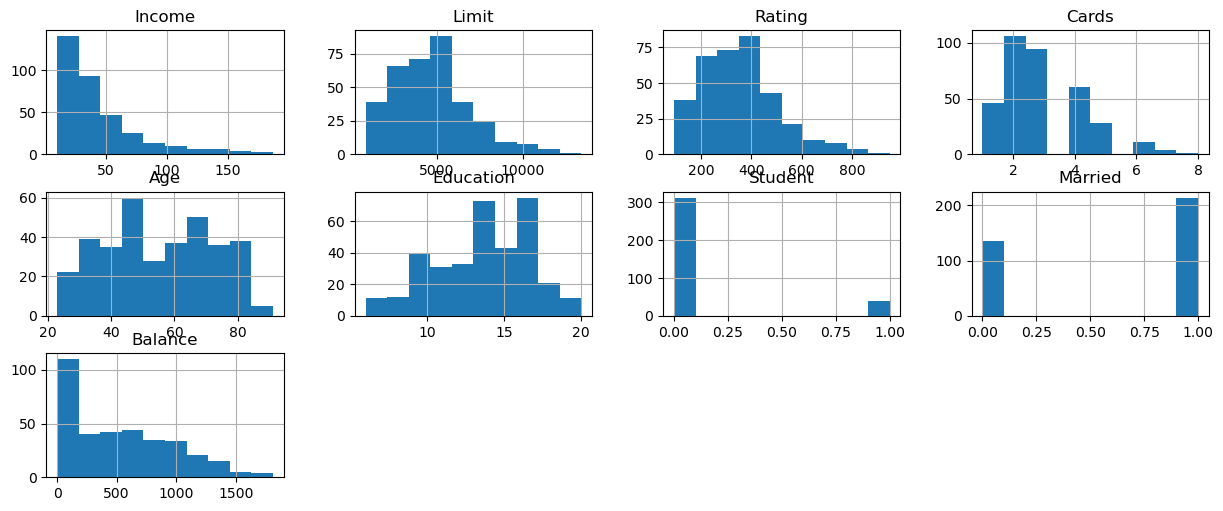

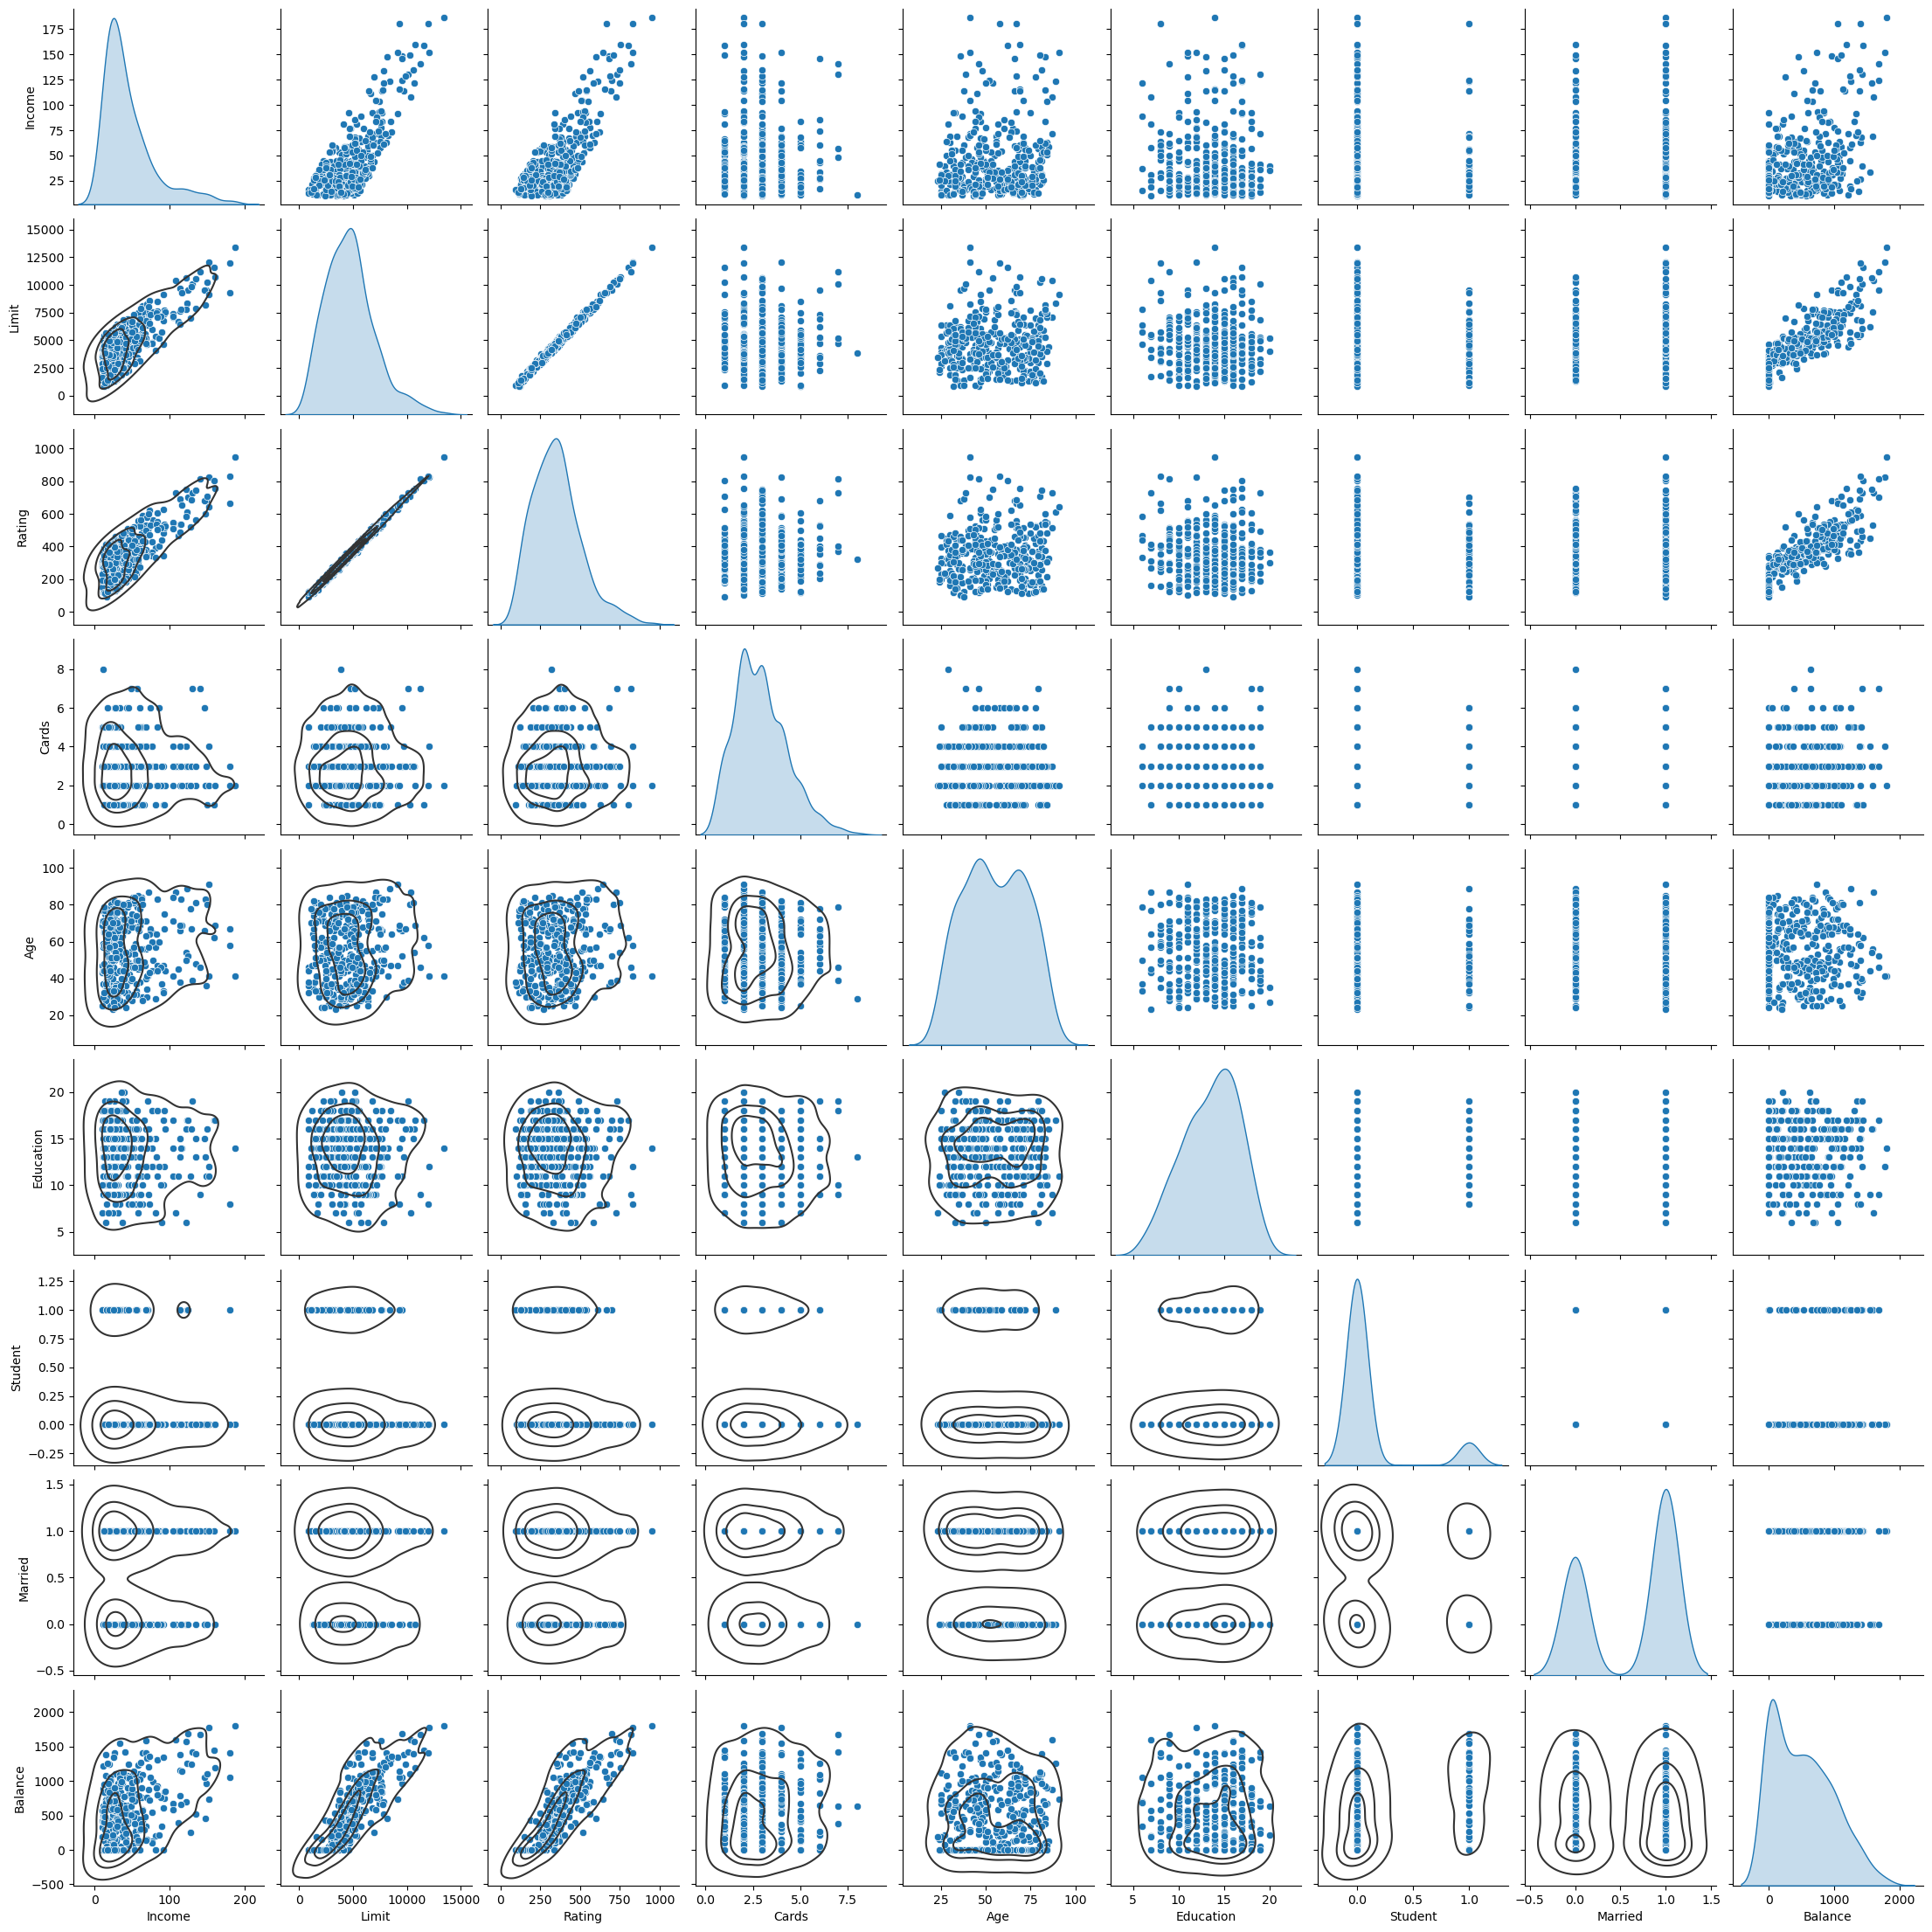

In [5]:
# Histogram Plotting of all Columns
df_plot.hist(layout=(5,4), figsize=(15,10))

plt.show()

# Exploratory Data Analysis - Pairplots
#sns.pairplot(df_plot, hue="Balance", diag_kind="hist")

g = sns.pairplot(df_plot, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

# MLPRegressor with KFolds as a baseline

In [6]:
# Define KFolds
def cross_validate(X, y, k):
    global KFold
    KFold = KFold(n_splits=k, random_state=None)
    for train_index , test_index in KFold.split(X):
        X_train , X_test = X[train_index],X[test_index]
        y_train , y_test = y[train_index] , y[test_index]
    return X_train , X_test, y_train , y_test

# Run Cross Validate
X_train , X_test, y_train , y_test = cross_validate (X_train, y_train, 5)


# Neural Network
mlp_base = MLPRegressor(hidden_layer_sizes=(100,100),alpha = 0.0001, batch_size = 'auto',
                  learning_rate = 'constant', learning_rate_init = 0.001,
                  max_iter = 10000, shuffle = True, random_state = None, warm_start = True,
                  momentum = True, early_stopping = False, validation_fraction = 0.1, 
                  beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8, )
mlp_base.fit(X_train, y_train)
pred_base = mlp_base.predict(X_test)
print("Baseline mean absolute error:",mean_absolute_error(pred_base,y_test))
pred_base = mlp_base.predict(X_test_df)

Baseline mean absolute error: 9.881109322436098


# MLPRegressor With Finetuning using GridSearchVC

In [7]:
start_time = time.time()

# GridSearchCV Finetuning
mlp = MLPRegressor(max_iter = 100000, activation = 'relu', learning_rate = 'adaptive') #tested with bigger parameter_space
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (1,100)],
    'alpha': [0.0001, 0.05]
}
search = GridSearchCV(mlp, parameter_space, cv=5, scoring='neg_mean_absolute_error', verbose=True, n_jobs=-1)
grid_result = search.fit(X_train, y_train)
# Set the new MLPRegressor Parameters
mlp.set_params(**search.best_params_)

elapsed_time = time.time() - start_time
print('GridSearchCV Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

# Run Fit
mlp.fit(X_train, y_train)
print(search.best_params_)
print(search.best_score_, "\n")
print(search.best_estimator_)

# Predict with KFold test set
pred = mlp.predict(X_test)
print("Finetuned mean absolute error:",mean_absolute_error(pred,y_test))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV Execution time: 00:01:08
{'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50)}
-18.433237396786712 

MLPRegressor(alpha=0.05, hidden_layer_sizes=(50, 100, 50),
             learning_rate='adaptive', max_iter=100000)
Finetuned mean absolute error: 10.702218085047727


# Test Expected Balances

In [8]:
pred = mlp.predict(X_test_df)

df_output = pd.DataFrame(columns=['Id','Expected'])
df_output.drop(df_output.index, inplace=True)
df_output['Id'] = df_test.index
df_output['Expected'] = pred.tolist()
#df_output.set_index('Id')
display(df_output)

df_output.to_csv('submission.csv', index = False)

,Id,Expected
0,2,922.424863
1,6,1114.928666
2,21,73.260190
3,31,851.031651
4,44,990.447660
5,54,969.358981
6,80,-0.866919
7,81,189.820541
8,90,1163.956621
9,91,1030.008507


# Summary Statistics

          Baseline    Finetuned
count    50.000000    50.000000
mean    511.328836   512.893806
std     486.358352   488.000275
min      -4.598189    -1.664194
25%      74.482943    74.948168
50%     455.400461   446.655603
75%     872.457859   863.654975
max    1996.937637  2049.308546


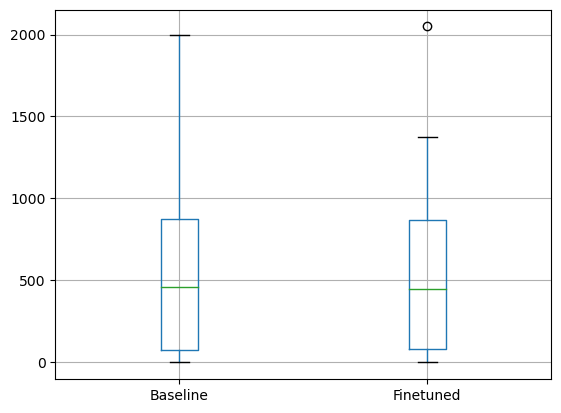

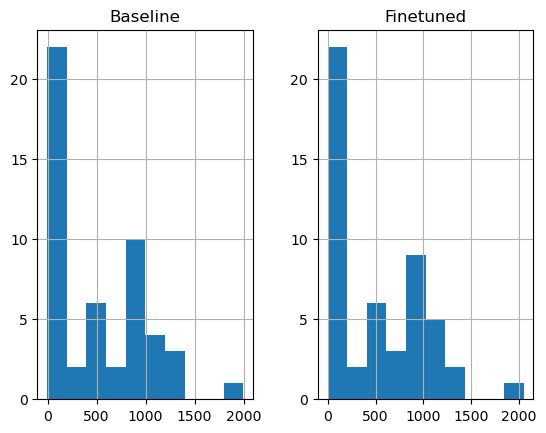

In [9]:
# load results file
results = pd.DataFrame()
results['Baseline'] = pred_base
results['Finetuned'] = pred
# descriptive stats
print(results.describe())
# box and whisker plot
results.boxplot()
plt.show()
# histogram
results.hist()
plt.show()

# Compare Means for Non-Gaussian Results

In [10]:
# calculate the significance
value, pvalue = ks_2samp(pred_base, pred)
print(value, pvalue)
if pvalue > 0.05:
 print('Samples are likely drawn from the same distributions (fail to reject H0)')
else:
 print('Samples are likely drawn from different distributions (reject H0)')

0.1 0.9667464356809096
Samples are likely drawn from the same distributions (fail to reject H0)
